In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [ ]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [ ]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
normalized_scan_val_set_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [6]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_val_set_sub = bvals_all_val_set[rand_sub_bval_indice_100206]*1e-3

In [7]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_val_set_sub = normalized_scan_val_set_full[:, rand_sub_bval_indice_100206]

In [8]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_val_set_sub = np.where(bvals_val_set_sub != 0.005)[0]

In [9]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_val_set_sub_no_b5 = bvals_val_set_sub[big_b_indice_val_set_sub]

In [10]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_val_set_sub_no_b5 = normalized_scan_val_set_sub[:, big_b_indice_val_set_sub]

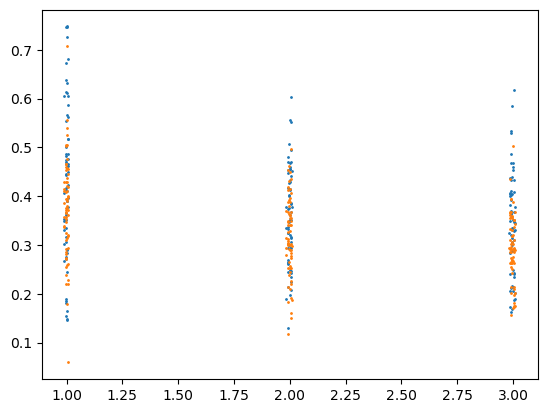

In [11]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set_sub_no_b5, normalized_scan_val_set_sub_no_b5[42,:], "o", markersize = 1)

In [12]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [13]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_val_set_sub = n_val_set_all[:, rand_sub_bval_indice_100206]
n_val_set_sub_no_b5 = n_val_set_sub[:,big_b_indice_val_set_sub].T
print(n_val_set_sub_no_b5.shape)

b_values_val_set_sub_no_b5 = torch.FloatTensor(bvals_val_set_sub_no_b5)
gradient_directions_val_set_sub_no_b5 = torch.FloatTensor(n_val_set_sub_no_b5)

(195, 3)
(195, 3)


In [14]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
batch_size = 128
val_num_batches = len(normalized_scan_val_set_sub_no_b5) // batch_size
valloader = utils.DataLoader(torch.from_numpy(normalized_scan_val_set_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [15]:
val_set = torch.from_numpy(normalized_scan_val_set_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([740145, 195])
<class 'torch.Tensor'>


In [ ]:
net = network.BallStickNet(len(b_values_val_set_sub_no_b5))
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_13g_01.pt"))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(valloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch,gradient_directions_val_set_sub_no_b5,b_values_val_set_sub_no_b5)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/val_num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/val_num_batches))
    
    net.eval()
    running_val_loss = 0.
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = net(val_set, gradient_directions_val_set_sub_no_b5, b_values_val_set_sub_no_b5)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss += val_loss.item()
    # val_loss_list.append(running_val_loss)
    print("Validation Loss: {}".format(running_val_loss))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net_golden_std.load_state_dict(final_model)

In [18]:
# bvals_num = len(b_values_100206_sub_no_b5)
# net = network.BallStickNet(bvals_num)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [19]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]

counter = 0

# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    

    if running_train_loss < best_train_loss:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best_train_loss = running_train_loss
        num_bad_epochs = 0
        
#         Validation
        val_net = network.BallStickNet(gradient_directions_val_set_sub_no_b5, b_values_val_set_sub_no_b5)
        val_net.load_state_dict(final_model)
        val_net.eval()
        with torch.no_grad():
            val_pred, _, _, _, _, _, _, _ = val_net(val_set)
            val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
            running_val_loss = val_loss.item()
            val_loss_list.append(running_val_loss)
            print("Validation Loss: {}".format(running_val_loss)) 
            if running_val_loss < best_val_loss:
                best_val_loss = running_val_loss
        
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best training loss: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.85it/s]


Loss: 1695.863875602372; Average Loss: 0.23205581220612642
############### Saving good model ###############################
Validation Loss: 0.044210195541381836
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.09it/s]


Loss: 432.70691132498905; Average Loss: 0.059210031653665715
############### Saving good model ###############################
Validation Loss: 0.03925824165344238
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.53it/s]


Loss: 422.36552098719403; Average Loss: 0.05779495361072715
############### Saving good model ###############################
Validation Loss: 0.038918569684028625
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.97it/s]


Loss: 420.983268418815; Average Loss: 0.05760581122315476
############### Saving good model ###############################
Validation Loss: 0.038719747215509415
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.27it/s]


Loss: 420.4877673047595; Average Loss: 0.05753800866239183
############### Saving good model ###############################
Validation Loss: 0.038844700902700424
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.23it/s]


Loss: 420.2126724696718; Average Loss: 0.057500365690978626
############### Saving good model ###############################
Validation Loss: 0.038622938096523285
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.80it/s]


Loss: 419.64178447937593; Average Loss: 0.05742224746570552
############### Saving good model ###############################
Validation Loss: 0.03860119357705116
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.52it/s]


Loss: 418.4753175131045; Average Loss: 0.057262632390955734
############### Saving good model ###############################
Validation Loss: 0.038655415177345276
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.92it/s]


Loss: 418.3444235245697; Average Loss: 0.05724472133614802
############### Saving good model ###############################
Validation Loss: 0.038697320967912674
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.24it/s]


Loss: 417.43305813195184; Average Loss: 0.057120013428017494
############### Saving good model ###############################
Validation Loss: 0.038379453122615814
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.88it/s]


Loss: 417.4087667716667; Average Loss: 0.057116689487091775
############### Saving good model ###############################
Validation Loss: 0.03850806877017021
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.32it/s]


Loss: 416.18545891949907; Average Loss: 0.056949296513341414
############### Saving good model ###############################
Validation Loss: 0.03828327730298042
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.44it/s]


Loss: 416.58722870703787; Average Loss: 0.05700427322209057
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.51it/s]


Loss: 415.693756876979; Average Loss: 0.05688201380363698
############### Saving good model ###############################
Validation Loss: 0.03827496990561485
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.69it/s]


Loss: 415.8674240577966; Average Loss: 0.05690577778568645
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.41it/s]


Loss: 414.8321348458994; Average Loss: 0.056764112595224334
############### Saving good model ###############################
Validation Loss: 0.03822006657719612
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.50it/s]


Loss: 415.04556413716637; Average Loss: 0.0567933174790868
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.28it/s]


Loss: 414.02567115984857; Average Loss: 0.05665375905307178
############### Saving good model ###############################
Validation Loss: 0.038057733327150345
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.95it/s]


Loss: 414.05512804398313; Average Loss: 0.05665778982539452
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.10it/s]


Loss: 413.40495915012434; Average Loss: 0.05656882309115002
############### Saving good model ###############################
Validation Loss: 0.03795939311385155
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.29it/s]


Loss: 413.25263976259157; Average Loss: 0.0565479802630804
############### Saving good model ###############################
Validation Loss: 0.03803529217839241
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.78it/s]


Loss: 412.18749474338256; Average Loss: 0.05640222971310654
############### Saving good model ###############################
Validation Loss: 0.037886131554841995
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.49it/s]


Loss: 411.8154292474501; Average Loss: 0.05635131763101397
############### Saving good model ###############################
Validation Loss: 0.037778060883283615
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.01it/s]


Loss: 411.0441315509379; Average Loss: 0.05624577607429364
############### Saving good model ###############################
Validation Loss: 0.037652887403964996
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.34it/s]


Loss: 411.0170941967517; Average Loss: 0.056242076381602585
############### Saving good model ###############################
Validation Loss: 0.037657346576452255
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.97it/s]


Loss: 410.33926169527695; Average Loss: 0.05614932426043746
############### Saving good model ###############################
Validation Loss: 0.03755774348974228
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.58it/s]


Loss: 410.2115413057618; Average Loss: 0.056131847469316064
############### Saving good model ###############################
Validation Loss: 0.037541527301073074
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.74it/s]


Loss: 409.9872145645786; Average Loss: 0.05610115141825104
############### Saving good model ###############################
Validation Loss: 0.03758487477898598
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.26it/s]


Loss: 409.51022379728965; Average Loss: 0.05603588174566087
############### Saving good model ###############################
Validation Loss: 0.037472013384103775
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.62it/s]


Loss: 408.98409158573486; Average Loss: 0.05596388773751161
############### Saving good model ###############################
Validation Loss: 0.037453170865774155
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.29it/s]


Loss: 408.74979836004786; Average Loss: 0.05593182790914722
############### Saving good model ###############################
Validation Loss: 0.037360742688179016
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.58it/s]


Loss: 408.5329919180367; Average Loss: 0.05590216090832467
############### Saving good model ###############################
Validation Loss: 0.03735531494021416
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.07it/s]


Loss: 408.2693508800585; Average Loss: 0.055866085232629786
############### Saving good model ###############################
Validation Loss: 0.03735340014100075
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.02it/s]


Loss: 407.91024441435; Average Loss: 0.0558169464168514
############### Saving good model ###############################
Validation Loss: 0.03732243925333023
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.49it/s]


Loss: 407.5859190521296; Average Loss: 0.055772566920105314
############### Saving good model ###############################
Validation Loss: 0.03722062334418297
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.42it/s]


Loss: 407.1917875551153; Average Loss: 0.0557186354071039
############### Saving good model ###############################
Validation Loss: 0.03719894215464592
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.06it/s]


Loss: 406.95964367571287; Average Loss: 0.0556868696874265
############### Saving good model ###############################
Validation Loss: 0.03719624504446983
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.39it/s]


Loss: 406.5572490186896; Average Loss: 0.055631807473821786
############### Saving good model ###############################
Validation Loss: 0.037125833332538605
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.82it/s]


Loss: 406.6161542451009; Average Loss: 0.05563986784963067
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.55it/s]


Loss: 406.4251193855889; Average Loss: 0.05561372733792952
############### Saving good model ###############################
Validation Loss: 0.03708149492740631
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.82it/s]


Loss: 406.08562152064405; Average Loss: 0.05556727169138534
############### Saving good model ###############################
Validation Loss: 0.03705896809697151
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:34<00:00, 76.97it/s]


Loss: 405.7699046805501; Average Loss: 0.05552407015333198
############### Saving good model ###############################
Validation Loss: 0.0370599590241909
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.42it/s]


Loss: 405.58000172208995; Average Loss: 0.055498084526832234
############### Saving good model ###############################
Validation Loss: 0.03698987513780594
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.91it/s]


Loss: 405.4749625986442; Average Loss: 0.05548371135723101
############### Saving good model ###############################
Validation Loss: 0.03705475106835365
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.21it/s]


Loss: 405.3795965926256; Average Loss: 0.055470661821651016
############### Saving good model ###############################
Validation Loss: 0.0369562953710556
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.42it/s]


Loss: 405.34693903732114; Average Loss: 0.055466193081187894
############### Saving good model ###############################
Validation Loss: 0.0369783379137516
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.86it/s]


Loss: 405.0698353496846; Average Loss: 0.0554282752257368
############### Saving good model ###############################
Validation Loss: 0.036950308829545975
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.76it/s]


Loss: 405.10102772549726; Average Loss: 0.055432543476395355
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.24it/s]


Loss: 404.9184040694963; Average Loss: 0.055407553923029054
############### Saving good model ###############################
Validation Loss: 0.03697012737393379
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.18it/s]


Loss: 404.8863000187557; Average Loss: 0.055403160922106696
############### Saving good model ###############################
Validation Loss: 0.036933064460754395
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.34it/s]


Loss: 404.87517603556626; Average Loss: 0.0554016387569193
############### Saving good model ###############################
Validation Loss: 0.03691892325878143
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.25it/s]


Loss: 404.6390031175688; Average Loss: 0.0553693217183318
############### Saving good model ###############################
Validation Loss: 0.0368560291826725
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.54it/s]


Loss: 404.4876694001723; Average Loss: 0.05534861376575976
############### Saving good model ###############################
Validation Loss: 0.03692128136754036
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.95it/s]


Loss: 404.22082772874273; Average Loss: 0.05531210012708576
############### Saving good model ###############################
Validation Loss: 0.036997854709625244
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.14it/s]


Loss: 404.24998111929744; Average Loss: 0.055316089370456685
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.30it/s]


Loss: 404.08078312827274; Average Loss: 0.05529293693599791
############### Saving good model ###############################
Validation Loss: 0.03688650205731392
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.94it/s]


Loss: 403.98513798974454; Average Loss: 0.055279849204945886
############### Saving good model ###############################
Validation Loss: 0.03685355931520462
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.92it/s]


Loss: 404.07997204572894; Average Loss: 0.05529282595042815
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.85it/s]


Loss: 404.0884619622957; Average Loss: 0.055293987679569744
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.91it/s]


Loss: 404.0601426679641; Average Loss: 0.055290112570876314
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 78.90it/s]


Loss: 403.7851442641113; Average Loss: 0.055252482794760714
############### Saving good model ###############################
Validation Loss: 0.03679635748267174
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.32it/s]


Loss: 403.82273979624733; Average Loss: 0.0552576272299189
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.49it/s]


Loss: 403.5304341255687; Average Loss: 0.05521762919069085
############### Saving good model ###############################
Validation Loss: 0.03676750883460045
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.32it/s]


Loss: 403.83408319507726; Average Loss: 0.05525917941914029
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.18it/s]


Loss: 403.4000908515882; Average Loss: 0.055199793493649174
############### Saving good model ###############################
Validation Loss: 0.03673214465379715
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.26it/s]


Loss: 403.4970386517234; Average Loss: 0.055213059476152626
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.21it/s]


Loss: 403.77717811218463; Average Loss: 0.05525139273565745
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.51it/s]


Loss: 403.3141090243589; Average Loss: 0.05518802805478365
############### Saving good model ###############################
Validation Loss: 0.036733586341142654
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.66it/s]


Loss: 403.1915570292622; Average Loss: 0.05517125848785744
############### Saving good model ###############################
Validation Loss: 0.03674694523215294
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.69it/s]


Loss: 403.2912576585077; Average Loss: 0.055184901157431264
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.59it/s]


Loss: 403.0939485251438; Average Loss: 0.055157902097036644
############### Saving good model ###############################
Validation Loss: 0.03675273805856705
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:31<00:00, 79.99it/s]


Loss: 403.3428358277306; Average Loss: 0.055191958925524164
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.13it/s]


Loss: 403.12440066435374; Average Loss: 0.05516206905642498
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:39<00:00, 73.33it/s]


Loss: 403.36674487777054; Average Loss: 0.055195230552513755
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.87it/s]


Loss: 402.8640758600086; Average Loss: 0.05512644716201541
############### Saving good model ###############################
Validation Loss: 0.03670942410826683
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.70it/s]


Loss: 402.80771983088925; Average Loss: 0.055118735609043415
############### Saving good model ###############################
Validation Loss: 0.03665919601917267
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.65it/s]


Loss: 402.9768245166633; Average Loss: 0.05514187527595284
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.50it/s]


Loss: 402.87523005576804; Average Loss: 0.05512797346138041
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.96it/s]


Loss: 402.822271209443; Average Loss: 0.05512072676648098
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.94it/s]


Loss: 402.8696373614948; Average Loss: 0.05512720817754445
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.34it/s]


Loss: 402.6023010353092; Average Loss: 0.055090626852122224
############### Saving good model ###############################
Validation Loss: 0.03663720190525055
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.46it/s]


Loss: 402.6006995730568; Average Loss: 0.055090407713882975
############### Saving good model ###############################
Validation Loss: 0.036718349903821945
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.83it/s]


Loss: 402.72624852485023; Average Loss: 0.05510758737340589
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.65it/s]


Loss: 402.57697650115006; Average Loss: 0.05508716153546114
############### Saving good model ###############################
Validation Loss: 0.03668484464287758
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.39it/s]


Loss: 402.58823029790074; Average Loss: 0.05508870146386162
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.14it/s]


Loss: 402.79798696073703; Average Loss: 0.05511740379867776
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.54it/s]


Loss: 402.5111512844451; Average Loss: 0.05507815425348181
############### Saving good model ###############################
Validation Loss: 0.03660885989665985
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 137.92it/s]


Loss: 402.5761685313191; Average Loss: 0.055087050975823636
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.06it/s]


Loss: 402.4763871205505; Average Loss: 0.05507339725240155
############### Saving good model ###############################
Validation Loss: 0.03662308678030968
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.10it/s]


Loss: 402.37171381385997; Average Loss: 0.05505907413982758
############### Saving good model ###############################
Validation Loss: 0.036609504371881485
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.84it/s]


Loss: 402.2844607520383; Average Loss: 0.0550471347498684
############### Saving good model ###############################
Validation Loss: 0.03659810498356819
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.01it/s]


Loss: 402.41554087074474; Average Loss: 0.05506507127404827
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.94it/s]


Loss: 402.4897679700516; Average Loss: 0.05507522823892332
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.12it/s]


Loss: 402.1255206083879; Average Loss: 0.0550253859617389
############### Saving good model ###############################
Validation Loss: 0.03663639351725578
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.76it/s]


Loss: 402.3800633531064; Average Loss: 0.05506021666024991
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.27it/s]


Loss: 402.4526745879557; Average Loss: 0.05507015251614063
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.13it/s]


Loss: 402.2309812225867; Average Loss: 0.05503981680659369
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.31it/s]


Loss: 402.2682775538415; Average Loss: 0.055044920300197246
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.39it/s]


Loss: 402.05998997669667; Average Loss: 0.05501641898969577
############### Saving good model ###############################
Validation Loss: 0.03659740462899208
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.79it/s]


Loss: 402.05117064574733; Average Loss: 0.05501521218469449
############### Saving good model ###############################
Validation Loss: 0.036626607179641724
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.58it/s]


Loss: 402.30772411846556; Average Loss: 0.05505031802387323
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.66it/s]


Loss: 401.9701386699453; Average Loss: 0.055004124065400284
############### Saving good model ###############################
Validation Loss: 0.03670729324221611
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.40it/s]


Loss: 402.1098518462386; Average Loss: 0.05502324190561557
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.39it/s]


Loss: 402.44186478224583; Average Loss: 0.055068673341850824
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.66it/s]


Loss: 402.07551344833337; Average Loss: 0.055018543164796575
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.19it/s]


Loss: 402.0978194880299; Average Loss: 0.05502159544171181
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.42it/s]


Loss: 402.25251711928286; Average Loss: 0.0550427636999566
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.45it/s]


Loss: 401.85891115060076; Average Loss: 0.0549889040983307
############### Saving good model ###############################
Validation Loss: 0.036530621349811554
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.10it/s]


Loss: 401.85345196002163; Average Loss: 0.05498815708265211
############### Saving good model ###############################
Validation Loss: 0.03652611002326012
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.87it/s]


Loss: 401.7751485402696; Average Loss: 0.05497744232899146
############### Saving good model ###############################
Validation Loss: 0.03658610209822655
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.93it/s]


Loss: 401.9431698631961; Average Loss: 0.055000433752489884
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.81it/s]


Loss: 401.9454931074288; Average Loss: 0.055000751656736284
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.11it/s]


Loss: 402.147824207088; Average Loss: 0.05502843790463711
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.43it/s]


Loss: 401.8730774000287; Average Loss: 0.05499084255610683
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.85it/s]


Loss: 401.7837988338433; Average Loss: 0.054978626003536306
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.92it/s]


Loss: 401.94857502309605; Average Loss: 0.05500117337480789
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.10it/s]


Loss: 401.8380966500845; Average Loss: 0.054986055918183424
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.11it/s]


Loss: 401.86893800320104; Average Loss: 0.05499027613617967
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.28it/s]


Loss: 401.91060890443623; Average Loss: 0.05499597822994475
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.75it/s]


Loss: 401.7172586962115; Average Loss: 0.054969520894391284
############### Saving good model ###############################
Validation Loss: 0.03649149835109711
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.89it/s]


Loss: 401.7018587314524; Average Loss: 0.05496741361952003
############### Saving good model ###############################
Validation Loss: 0.03649265319108963
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.68it/s]


Loss: 401.61345287109725; Average Loss: 0.054955316484824476
############### Saving good model ###############################
Validation Loss: 0.03651801496744156
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.60it/s]


Loss: 401.56868724082597; Average Loss: 0.05494919091965325
############### Saving good model ###############################
Validation Loss: 0.03651868551969528
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.71it/s]


Loss: 401.65093962824903; Average Loss: 0.054960446035611524
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 128.17it/s]


Loss: 401.5411963330116; Average Loss: 0.05494542916434204
############### Saving good model ###############################
Validation Loss: 0.03652073070406914
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.69it/s]


Loss: 401.55058307689615; Average Loss: 0.054946713612054755
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.34it/s]


Loss: 401.6414601155557; Average Loss: 0.054959148893754195
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.00it/s]


Loss: 401.975912013324; Average Loss: 0.05500491406859934
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.74it/s]


Loss: 401.59335420886055; Average Loss: 0.05495256625737008
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.61it/s]


Loss: 401.6839971905574; Average Loss: 0.05496496951157053
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.56it/s]


Loss: 401.54690088145435; Average Loss: 0.05494620975389359
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.13it/s]


Loss: 401.4687039309647; Average Loss: 0.05493550956909752
############### Saving good model ###############################
Validation Loss: 0.036464981734752655
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.85it/s]


Loss: 401.50215193186887; Average Loss: 0.05494008647124642
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.70it/s]


Loss: 401.60033475398086; Average Loss: 0.05495352144964161
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.59it/s]


Loss: 401.4999767979607; Average Loss: 0.0549397888338753
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.17it/s]


Loss: 401.5085468632169; Average Loss: 0.05494096153027051
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.27it/s]


Loss: 401.56370245153084; Average Loss: 0.05494850881931183
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.15it/s]


Loss: 401.38303600484505; Average Loss: 0.05492378708331213
############### Saving good model ###############################
Validation Loss: 0.03649333864450455
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.02it/s]


Loss: 401.4300651308149; Average Loss: 0.0549302223769588
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.31it/s]


Loss: 401.42068327590823; Average Loss: 0.05492893859823594
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.26it/s]


Loss: 401.5400878514629; Average Loss: 0.054945277483779816
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.59it/s]


Loss: 401.3527048865799; Average Loss: 0.054919636683987395
############### Saving good model ###############################
Validation Loss: 0.03646627068519592
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.43it/s]


Loss: 401.64205876737833; Average Loss: 0.05495923081108078
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.16it/s]


Loss: 401.4530836539343; Average Loss: 0.05493337214750059
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.93it/s]


Loss: 401.4990322717931; Average Loss: 0.05493965958836797
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.32it/s]


Loss: 401.4934487028513; Average Loss: 0.054938895553208994
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.98it/s]


Loss: 401.33447954268195; Average Loss: 0.054917142794565124
############### Saving good model ###############################
Validation Loss: 0.03648386895656586
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.44it/s]


Loss: 401.28592948033474; Average Loss: 0.05491049938154553
############### Saving good model ###############################
Validation Loss: 0.036485109478235245
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.04it/s]


Loss: 401.4255956048146; Average Loss: 0.0549296107833627
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.34it/s]


Loss: 401.2372327018529; Average Loss: 0.054903835892426506
############### Saving good model ###############################
Validation Loss: 0.036466047167778015
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.59it/s]


Loss: 401.29233046714216; Average Loss: 0.05491137526917654
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.67it/s]


Loss: 401.30734069109894; Average Loss: 0.0549134292133414
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.97it/s]


Loss: 401.30536245787516; Average Loss: 0.054913158519140005
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.35it/s]


Loss: 401.1742161596194; Average Loss: 0.054895212939192584
############### Saving good model ###############################
Validation Loss: 0.036438506096601486
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.89it/s]


Loss: 401.2043940636795; Average Loss: 0.05489934237324569
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.65it/s]


Loss: 401.2492231349461; Average Loss: 0.05490547661945075
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.10it/s]


Loss: 401.17243105429225; Average Loss: 0.054894968671906436
############### Saving good model ###############################
Validation Loss: 0.03654837608337402
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.39it/s]


Loss: 401.49071464524604; Average Loss: 0.05493852143476273
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.18it/s]


Loss: 401.04370363615453; Average Loss: 0.0548773540826703
############### Saving good model ###############################
Validation Loss: 0.036422040313482285
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.46it/s]


Loss: 401.1783131333068; Average Loss: 0.054895773554092336
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.48it/s]


Loss: 401.23784383176826; Average Loss: 0.054903919517209666
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.46it/s]


Loss: 401.16205423278734; Average Loss: 0.05489354874559214
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.85it/s]


Loss: 401.0980241626967; Average Loss: 0.05488478710491197
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 114.17it/s]


Loss: 401.1051593909506; Average Loss: 0.054885763463457936
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:34<00:00, 76.98it/s]


Loss: 401.0741733426694; Average Loss: 0.054881523445904405
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.64it/s]


Loss: 401.22905585658737; Average Loss: 0.0549027170028171
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.12it/s]


Loss: 401.3365476669278; Average Loss: 0.05491742578912531
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.37it/s]


Loss: 401.3064264403656; Average Loss: 0.05491330411061379
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.20it/s]


Loss: 401.1610639372375; Average Loss: 0.05489341323716988
Done, best training loss: 401.04370363615453; best validation loss: 0.036422040313482285
Done


NameError: name 'fina_model' is not defined

In [20]:
net.load_state_dict(final_model)

<All keys matched successfully>

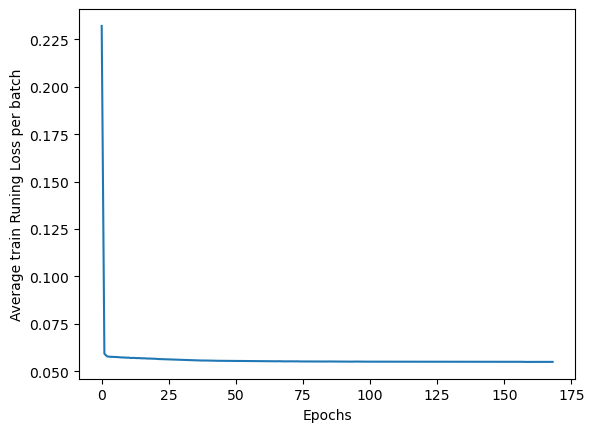

In [21]:
epoch_arr = np.arange(0, len(avg_train_loss_list))
loss_arr = np.array(avg_train_loss_list)
plt.plot(avg_train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average train Runing Loss per batch")
plt.show()

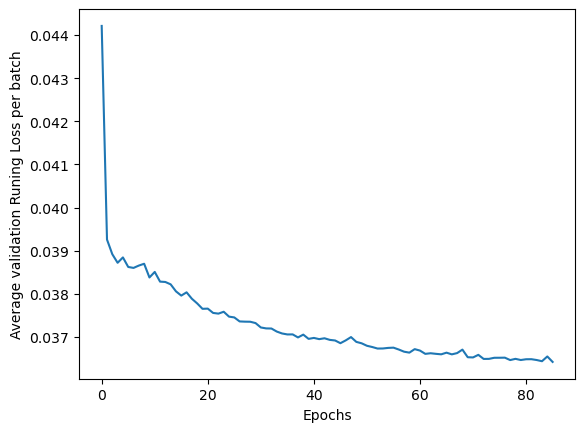

In [22]:
epoch_arr = np.arange(0, len(val_loss_list))
loss_arr = np.array(val_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average validation Runing Loss per batch")
plt.show()

In [23]:
torch.save(final_model, 'model_100206_13g_01_retrain2.pt')